In [1]:
# installing kaggle library

!pip install kaggle

In [2]:
# uploading kaggle.json file
# configuring the path of kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
# API to fetch the dataset from kaggle

!kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset

Dataset URL: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
License(s): CC0-1.0
  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 71.0MB/s]


In [4]:
# extracting the compressed dataset

from zipfile import ZipFile
dataset = '/content/hate-speech-and-offensive-language-dataset.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("Dataset is Extracted")

Dataset is Extracted


In [5]:
!pip install scikit-learn==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [6]:
import numpy as np
import pandas as pd
import re
import nltk
import random
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.metrics import accuracy_score

from tqdm import tqdm
tqdm.pandas()

In [7]:
# loading data from csv file

df = pd.read_csv('labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
df.isnull().sum()

,0
Unnamed: 0,0
count,0
hate_speech,0
offensive_language,0
neither,0
class,0
tweet,0


<ipython-input-9-404830da083c>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(),rotation=40,ha="right")


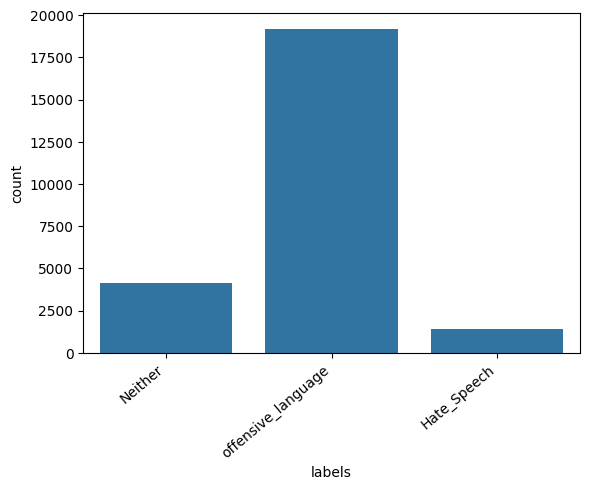

In [9]:
# adding new column to dataset as lables

df['labels'] = df['class'].map({0:'Hate_Speech',1:'offensive_language',
                                  2: 'Neither'})


fig, axs = plt.subplots(figsize=(6,5))
sns.countplot(x='labels',data=df,ax=axs)
axs.set_xticklabels(axs.get_xticklabels(),rotation=40,ha="right")
plt.tight_layout()
plt.show()

In [10]:
# selecting tweet and labels column

new_df = df[['tweet', 'labels']]
new_df.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,Neither
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language


In [14]:
# downloading NLTK resources

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# initializing lemmatizer and stopwords

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# function for cleaning text

def clean_text(text):

  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)

  # Remove mentions
  text = re.sub(r'@\w+|[^a-zA-Z\s]', '', text)

  # Convert to lowercase
  text = text.lower()

  # Tokenization
  tokens = word_tokenize(text)

  # Remove stopwords and lemmatize
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
  return ' '.join(tokens)

In [17]:
# Applying cleaning function to the text column in dataset

new_df.loc[:, 'tweet'] = new_df['tweet'].progress_apply(clean_text)

100%|██████████| 24783/24783 [00:03<00:00, 6650.03it/s]


In [18]:
new_df.head()

,tweet,labels
0,rt woman shouldnt complain cleaning house amp ...,Neither
1,rt boy dat coldtyga dwn bad cuffin dat hoe st ...,offensive_language
2,rt dawg rt ever fuck bitch start cry confused ...,offensive_language
3,rt look like tranny,offensive_language
4,rt shit hear might true might faker bitch told ya,offensive_language


In [19]:
df['labels'].value_counts()

,count
labels,
offensive_language,19190
Neither,4163
Hate_Speech,1430


In [20]:
X = new_df['tweet'].values
y = new_df['labels'].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
print(X_train.shape, X_test.shape)

(19826,) (4957,)


In [30]:
#TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [31]:
# Handle class imbalance using oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)
}

model_performance = {}
best_model_name = None
best_model_score = 0

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)  # Use TF-IDF transformed data for training

    y_train_pred = model.predict(X_train_tfidf)
    y_test_pred = model.predict(X_test_tfidf)

    # Calculate performance metrics
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=1)
    precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Store performance metrics
    model_performance[model_name] = {
        "Training Accuracy": training_accuracy,
        "Testing Accuracy": testing_accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1 Score": f1
    }

    print(f"Model: {model_name}")
    print(f"Training Accuracy: {training_accuracy:.4f}")
    print(f"Testing Accuracy: {testing_accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("--" * 20)

    # Check if this model is the best so far
    if testing_accuracy > best_model_score:
        best_model_score = testing_accuracy
        best_model_name = model_name
        best_model = model

# Print the best model
print(f"Best Model: {best_model_name} with Testing Accuracy: {best_model_score:.4f}")


Model: Logistic Regression
Training Accuracy: 0.9311
Testing Accuracy: 0.8941
Recall: 0.8941
Precision: 0.8797
F1 Score: 0.8811
----------------------------------------
Model: Naive Bayes
Training Accuracy: 0.8617
Testing Accuracy: 0.8332
Recall: 0.8332
Precision: 0.8493
F1 Score: 0.7897
----------------------------------------
Model: Decision Tree
Training Accuracy: 0.9958
Testing Accuracy: 0.8725
Recall: 0.8725
Precision: 0.8694
F1 Score: 0.8709
----------------------------------------
Model: Random Forest
Training Accuracy: 0.9957
Testing Accuracy: 0.8901
Recall: 0.8901
Precision: 0.8719
F1 Score: 0.8749
----------------------------------------
Model: SVM
Training Accuracy: 0.9339
Testing Accuracy: 0.8957
Recall: 0.8957
Precision: 0.8786
F1 Score: 0.8802
----------------------------------------
Best Model: SVM with Testing Accuracy: 0.8957


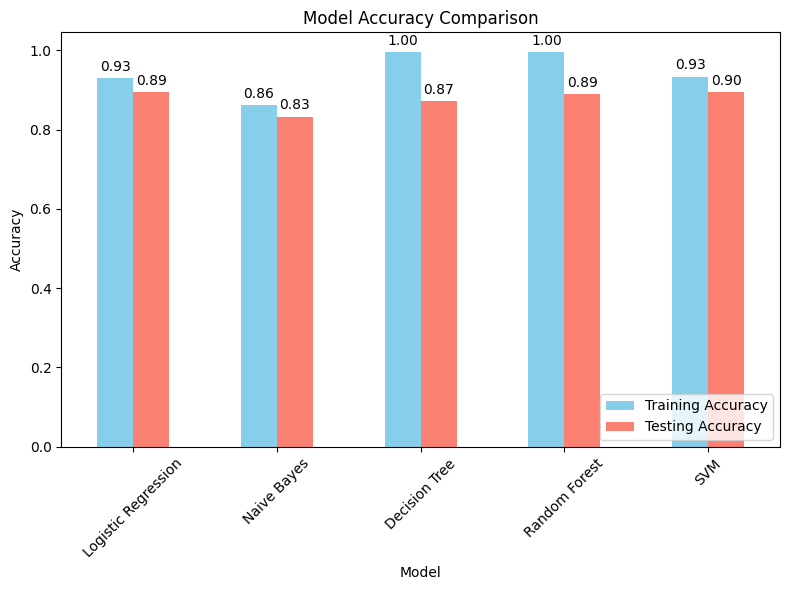

In [33]:
# Convert model_performance dictionary to a DataFrame
performance_df = pd.DataFrame(model_performance).T

# Select only Training and Testing Accuracy for plotting
accuracy_df = performance_df[["Training Accuracy", "Testing Accuracy"]]

# Plotting
ax = accuracy_df.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'salmon'])
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(loc='lower right')

# Annotate each bar with the actual value
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()  # Adjust layout for better appearance
plt.show()


In [34]:
# saving the model

import pickle

# Save the best model using pickle
if best_model_name:
    with open(f"{best_model_name.replace(' ', '_')}_hate_speech_model.pkl", "wb") as file:
        pickle.dump(best_model, file)
    print(f"Best model '{best_model_name}' saved as '{best_model_name.replace(' ', '_')}_hate_speech_model.pkl'")

Best model 'SVM' saved as 'SVM_hate_speech_model.pkl'


In [35]:
# loading the saved model

loaded_model = pickle.load(open('/content/SVM_hate_speech_model.pkl','rb'))

In [37]:
for _ in range(20):
    random_index = random.randint(0, X_test.shape[0] - 1)

    # Get the corresponding raw text and transform it using the vectorizer
    X_new = vectorizer.transform([X_test[random_index]])  # Transform the raw text to TF-IDF

    true_label = y_test[random_index]

    # Predict using the model
    prediction = model.predict(X_new)

    print(f"True Label: {true_label}, Prediction: {prediction[0]}")


True Label: offensive_language, Prediction: offensive_language
True Label: Hate_Speech, Prediction: offensive_language
True Label: offensive_language, Prediction: offensive_language
True Label: offensive_language, Prediction: offensive_language
True Label: offensive_language, Prediction: offensive_language
True Label: offensive_language, Prediction: offensive_language
True Label: offensive_language, Prediction: offensive_language
True Label: Neither, Prediction: Neither
True Label: offensive_language, Prediction: offensive_language
True Label: Neither, Prediction: Neither
True Label: offensive_language, Prediction: offensive_language
True Label: offensive_language, Prediction: offensive_language
True Label: offensive_language, Prediction: offensive_language
True Label: offensive_language, Prediction: offensive_language
True Label: Neither, Prediction: Neither
True Label: Neither, Prediction: Neither
True Label: offensive_language, Prediction: offensive_language
True Label: offensive_la

In [38]:
from google.colab import files

# Replace 'SVM_hate_speech_model.pkl' with your actual file name
files.download('SVM_hate_speech_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
with open("tfidf_vectorizer_hate.pkl", "wb") as vec_file:
    pickle.dump(vectorizer, vec_file)

In [40]:
from google.colab import files
files.download('tfidf_vectorizer_hate.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>